In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import glob
import random

## Configuration

In [2]:
# Number of force cells in the robotic leg
N_CELLS = 8

# Directory where the derived data is stored
DERIVED_DATA_DIR = '../../../../data'

# Path where the results are stored
RESULTS_PATH = '../../../../results'
# ID of the training and validation data resulting from this notebook, stored in RESULTS_PATH
DATA_ID = '0006_14062021'
# Number of folds for cross-validation
CV = 6

# Percentage of the date for the test set
TEST_SIZE = 0.3

print('Model training with data: ' + DATA_ID)

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', TORCH_DEVICE)

Model training with data: 0006_14062021
Using device: cuda


## Load data

In [3]:
exp_path = glob.glob(DERIVED_DATA_DIR + '/*/*')[0]
exp_path

'../../../../data/10032021/1'

In [4]:
H3_LEG = 'L' # L|R

# features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]
features = [H3_LEG + a + m for a in ['Hip', 'Knee'] for m in ['Pos', 'Torque']]
targets = ['F3z'] #['F' + str(i + 1) + ax for i in range(N_CELLS) for ax in ['x', 'y', 'z']]

print('Number of features: {}'.format(len(features)))
print('Selected features: {}'.format(features))
print('\n')
print('Number of targets: {}'.format(len(targets)))
print('Selected targets: {}'.format(targets))

Number of features: 4
Selected features: ['LHipPos', 'LHipTorque', 'LKneePos', 'LKneeTorque']


Number of targets: 1
Selected targets: ['F3z']


In [5]:
# Load targets
targets_df = pd.read_csv(exp_path + '/force_cells_processed.csv')

# Load features
exo_df = pd.read_csv(exp_path + '/H3_processed.csv')
# leg_df = pd.read_csv(exp_path + '/leg_processed.csv')
# features_df = pd.concat([exo_df, leg_df], axis=1)
features_df = exo_df

idx_aux = targets_df.duplicated(keep='first')
targets_df = targets_df.loc[~idx_aux]
features_df = features_df.loc[~idx_aux]
print('Droping {} duplicated data points'.format(len(idx_aux[idx_aux == False])))

# Drop first row to remove noise in the start of the data recording
targets_df = targets_df.iloc[1:]
features_df = features_df.iloc[1:]
# Drop null values
idx = features_df.notna().all(axis=1)
features_df = features_df.loc[idx]
targets_df = targets_df.loc[idx]
print('Droping {} data points by null features'.format(len(idx[idx == False])))

assert(len(features_df) == len(targets_df))
# Store the final array
targets_arr = targets_df[targets].values
features_arr = features_df[features].values

print('X: {}, Y: {} \n'.format(features_arr.shape, targets_arr.shape))

Droping 2917 duplicated data points
Droping 0 data points by null features
X: (2916, 4), Y: (2916, 1) 



In [6]:
idx_split = int(targets_arr.shape[0] * (1 - TEST_SIZE))

X_train = features_arr[:idx_split, :]
X_test = features_arr[idx_split:, :]

Y_train = targets_arr[:idx_split, :]
Y_test = targets_arr[idx_split:, :]

print('Train -> X: {}, Y: {}'.format(X_train.shape, Y_train.shape))
print('Test -> X: {}, Y: {}'.format(X_test.shape, Y_test.shape))

Train -> X: (2041, 4), Y: (2041, 1)
Test -> X: (875, 4), Y: (875, 1)


In [7]:
s = MinMaxScaler().fit(X_train)

X_train_norm = s.transform(X_train)
X_test_norm = s.transform(X_test)

print('Train -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_train_norm, axis=0), np.max(X_train_norm, axis=0), np.mean(X_train_norm, axis=0), np.std(X_train_norm, axis=0)))
print('Test -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_test_norm, axis=0), np.max(X_test_norm, axis=0), np.mean(X_test_norm, axis=0), np.std(X_test_norm, axis=0)))

Train -> 
 min: [0. 0. 0. 0.], 
 max: [1. 1. 1. 1.], 
 mean: [0.43120976 0.40218019 0.22651369 0.45789431], 
 std: [0.33894781 0.24077308 0.29944424 0.2707551 ]

Test -> 
 min: [1.14634060e-03 1.39308522e-02 4.82467537e-06 3.17798687e-03], 
 max: [0.9996938  1.01692898 0.99964499 1.00058556], 
 mean: [0.44434938 0.40818974 0.23605292 0.4485459 ], 
 std: [0.34514506 0.24614727 0.30620312 0.27769232]



In [12]:
SEQUENCE_LEN = 10

splits = [i for i in range(0, X_train_norm.shape[0], SEQUENCE_LEN)]

X_train_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
Y_train_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
for idx, i in enumerate(splits[:-1]):
    X_train_norm_tensor[idx, :, :] = X_train_norm[splits[idx]:splits[idx + 1], :]
    Y_train_tensor[idx, :, :] = Y_train[splits[idx + 1] - 1, :]
        
print(X_train_norm_tensor.shape)
print(Y_train_tensor.shape)

(205, 10, 4)
(205, 10, 1)


In [13]:
splits = [i for i in range(0, X_test_norm.shape[0], SEQUENCE_LEN)]

X_test_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
Y_test_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
for idx, i in enumerate(splits[:-1]):
    X_test_norm_tensor[idx, :, :] = X_test_norm[splits[idx]:splits[idx + 1], :]
    Y_test_tensor[idx, :, :] = Y_test[splits[idx + 1] - 1, :]
        
print(X_test_norm_tensor.shape)
print(Y_test_tensor.shape)

(88, 10, 4)
(88, 10, 1)


## Recurrent Neural Network

In [39]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, sigma, output_size, sequence_length, num_iter, n_layers, device, lr=0.001, batch_size=16):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.sigma = sigma
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.num_layers = n_layers
        
        # define an RNN with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, 
                          nonlinearity='relu', batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

        
        self.lr = lr #Learning Rate
        self.batch_size = batch_size
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.num_iter = num_iter
        self.criterion = nn.MSELoss() #YOUR CODE HERE     
        
        self.device = device
        self.to(self.device)
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        #print(x.shape)
        r_out, hidden = self.rnn(x, h0)
        #print(r_out.shape, hidden.shape)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        #print(r_out.shape)
        
        output = self.fc1(r_out)
        #print(output.shape)
        
        noise = torch.randn_like(output) * self.sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1, self.sequence_length, 1])

        return output, hidden
           
    def trainloop(self, x, y, x_val=None, y_val=None):
        
        # SGD Loop
        for e in range(int(self.num_iter)):
        
            running_loss = 0.
            
            idx = list(range(x.shape[0]))
            random.shuffle(idx)
            
            batchs = [idx[i:i + self.batch_size] for i in range(0, x_val.shape[0], self.batch_size)]
            for b in batchs:

                features = x[b, :, :]
                target = y[b, :, :]

                # print(features.shape, target.shape)
                self.optim.zero_grad() 
                
                features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  
                
                out,hid = self.forward(features)

                # print(out.shape, hid.shape, target.shape)
                # print(out[:, -1, 0].size(), target[:, 0].size())
                loss = self.criterion(out[:, -1, 0], target[:, 0]) #YOUR CODE HERE
                running_loss += loss.item()

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
                
            self.loss_during_training.append(running_loss / len(batchs))
            
            if x_val is not None and y_val is not None:
                with torch.no_grad():
                    # Set the model in evaluation mode 
                    self.eval()

                    running_loss_val = 0.
                    idx = list(range(x_val.shape[0]))

                    batchs = [idx[i:i + self.batch_size] for i in range(0, x_val.shape[0], self.batch_size)]
                    for b in batchs:
                        features = x_val[b, :, :]
                        target = y_val[b, :, :]

                        features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                        target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  

                        out,hid = self.forward(features)

                        # print(out.shape, hid.shape, target.shape)
                        # print(out[:, -1, 0].size(), target[:, -1, 0].size())
                        loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                        running_loss_val += loss.item()

                    self.valid_loss_during_training.append(running_loss_val / len(splits))

                # Return the model to training mode
                self.train()

                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f - Val loss: %f"%(e, self.loss_during_training[-1], self.valid_loss_during_training[-1]))
                    
            else:
                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f"%(e, self.loss_during_training[-1]))

                

In [40]:
model = RNN(input_size=4, hidden_dim=32, sigma=1, output_size=1, sequence_length=SEQUENCE_LEN, 
            num_iter=200, n_layers=1, device=TORCH_DEVICE)

In [41]:
model.trainloop(X_train_norm_tensor, Y_train_tensor, X_test_norm_tensor, Y_test_tensor)

0 epochs -> Train loss: 2155.346517 - Val loss: 153.378196
1 epochs -> Train loss: 2196.168111 - Val loss: 153.355965
2 epochs -> Train loss: 2364.771973 - Val loss: 152.289470
3 epochs -> Train loss: 2349.584676 - Val loss: 150.906526
4 epochs -> Train loss: 2269.420492 - Val loss: 150.767725
5 epochs -> Train loss: 2413.207804 - Val loss: 149.656582
6 epochs -> Train loss: 2242.696716 - Val loss: 147.900196
7 epochs -> Train loss: 2108.562622 - Val loss: 142.128602
8 epochs -> Train loss: 2073.848429 - Val loss: 132.324019
9 epochs -> Train loss: 1942.443197 - Val loss: 109.347472
10 epochs -> Train loss: 1412.005788 - Val loss: 67.882650
11 epochs -> Train loss: 775.150070 - Val loss: 29.188711
12 epochs -> Train loss: 375.795489 - Val loss: 60.883393
13 epochs -> Train loss: 586.262614 - Val loss: 44.476779
14 epochs -> Train loss: 338.781413 - Val loss: 26.688408
15 epochs -> Train loss: 306.162959 - Val loss: 26.811367
16 epochs -> Train loss: 253.812345 - Val loss: 28.445119
17 

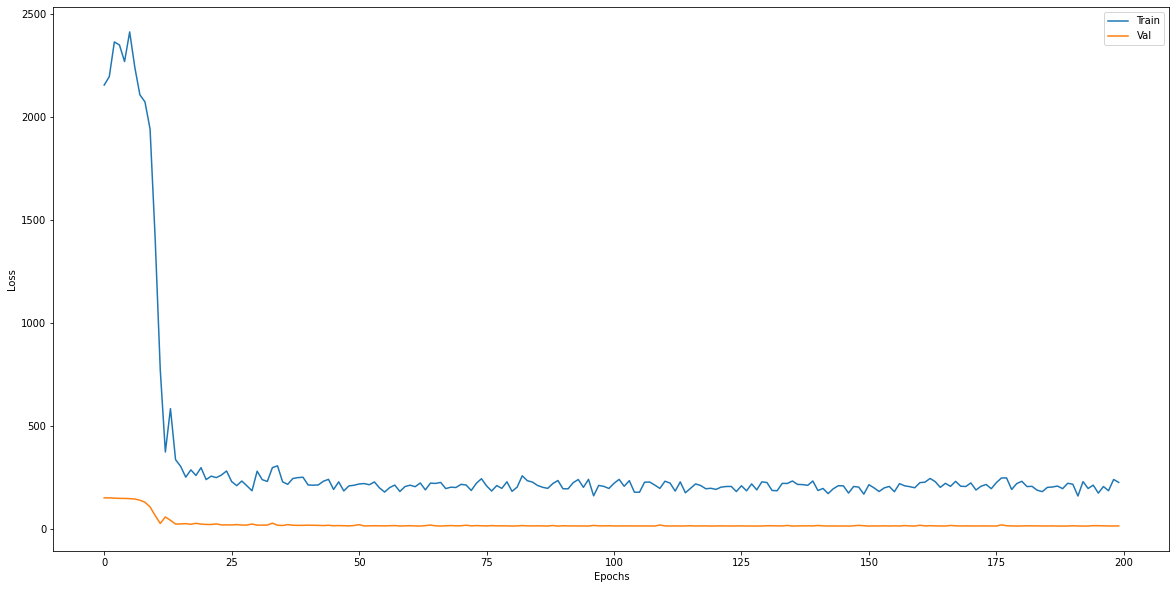

In [42]:
plt.figure(figsize=(20,10))

plt.plot(model.loss_during_training, label='Train')
plt.plot(model.valid_loss_during_training, label='Val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

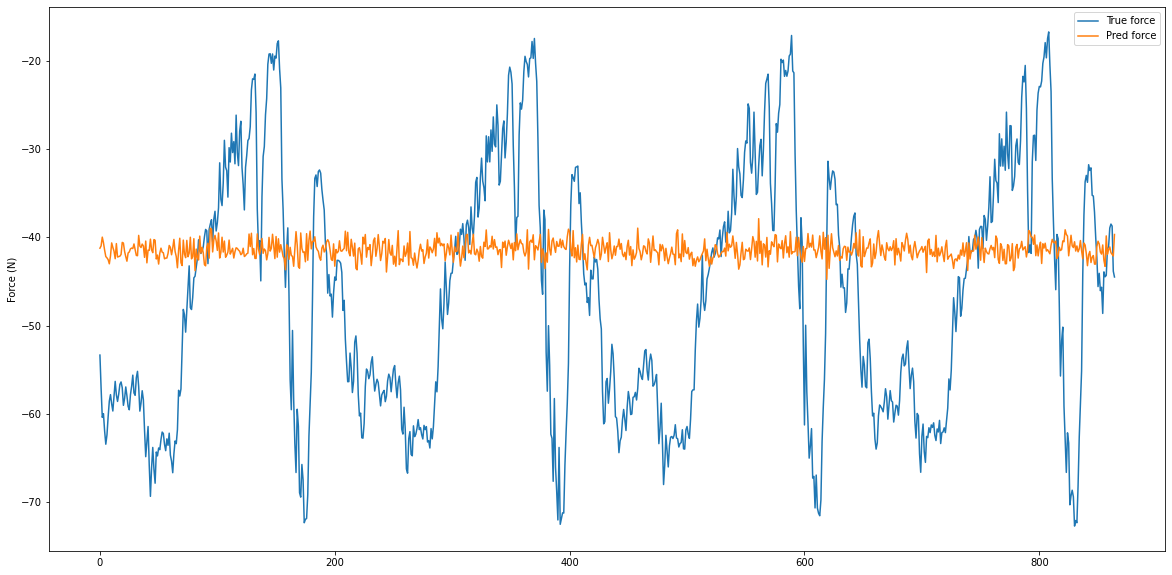

In [45]:
true = []
pred = []

for i in range(SEQUENCE_LEN, X_test_norm.shape[0]):
    features_ = torch.Tensor(X_test_norm[np.newaxis, i-SEQUENCE_LEN:i, :]).to(TORCH_DEVICE)
    target_ = torch.Tensor(Y_test[np.newaxis, i, :]).to(TORCH_DEVICE)
    
    out, hid = model.forward(features_)

    true.append(target_[:, 0].cpu().detach().numpy())
    pred.append(out[:, -1, 0].cpu().detach().numpy())
    
plt.figure(figsize=(20,10))

plt.plot(true, label='True force')
plt.plot(pred, label='Pred force')

plt.legend()
plt.ylabel('Force (N)')
plt.show()